In [829]:
# Import Python packages
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import biom
from biom import load_table
import numpy as np
from scipy.stats import pearsonr
from matplotlib_venn import venn2
import matplotlib.patches as mpatches
from scipy.stats import mannwhitneyu
from biom import Table
from gemelli.rpca import rpca
from scipy.spatial.distance import euclidean
from statsmodels.stats.multitest import multipletests
from scipy.stats import kruskal


In [830]:
# Load the metadata
metadata_path = '../Data/Metadata/updated_clean_ant_skin_metadata_microbiome_type.tab'
metadata = pd.read_csv(metadata_path, sep='\t')

metadata['#sample-id'] = metadata['#sample-id'].str.replace('_', '')
# Set Sample-ID as the index for the metadata dataframe 
metadata = metadata.set_index('#sample-id')


# Create group column based on case_type to simplify group names
metadata['group'] = metadata['case_type'].map({
    'case-lesional skin': 'skin-ADL',
    'case-nonlesional skin': 'skin-ADNL', 
    'control-nonlesional skin': 'skin-H',
    'case-anterior nares': 'nares-AD',
    'control-anterior nares': 'nares-H'
})

# Add AD status column based on group values
metadata['ad_status'] = metadata['group'].apply(lambda x: 'AD' if x.split('-')[-1].startswith('AD') else 'H')

metadata

,PlateNumber,PlateLocation,i5,i5Sequence,i7,i7Sequence,identifier,Sequence,Plate ID,Well location,...,enrolment_season,hiv_exposure,hiv_status,household_size,o_scorad,FWD_filepath,REV_filepath,group,microbiome_type,ad_status
#sample-id,,,,,,,,,,,,,,,,,,,,,
Ca009STL,1,A1,SA501,ATCGTACG,SA701,CGAGAGTT,SA701SA501,CGAGAGTT-ATCGTACG,1.010000e+21,A1,...,Autumn,Unexposed,negative,4.0,40,/Users/yac027/Gallo_lab/16S_AD_Dube_Dupont/ato...,/Users/yac027/Gallo_lab/16S_AD_Dube_Dupont/ato...,skin-ADL,skin,AD
900221,1,B1,SA502,ACTATCTG,SA701,CGAGAGTT,SA701SA502,CGAGAGTT-ACTATCTG,1.010000e+21,B1,...,Winter,Unexposed,negative,7.0,34,/Users/yac027/Gallo_lab/16S_AD_Dube_Dupont/ato...,/Users/yac027/Gallo_lab/16S_AD_Dube_Dupont/ato...,skin-ADL,skin,AD
Ca010EBL,1,C1,SA503,TAGCGAGT,SA701,CGAGAGTT,SA701SA503,CGAGAGTT-TAGCGAGT,1.010000e+21,C1,...,Spring,Unexposed,negative,7.0,21,/Users/yac027/Gallo_lab/16S_AD_Dube_Dupont/ato...,/Users/yac027/Gallo_lab/16S_AD_Dube_Dupont/ato...,skin-ADL,skin,AD
900460,1,D1,SA504,CTGCGTGT,SA701,CGAGAGTT,SA701SA504,CGAGAGTT-CTGCGTGT,1.010000e+21,D1,...,Spring,Unexposed,NaN,4.0,40,/Users/yac027/Gallo_lab/16S_AD_Dube_Dupont/ato...,/Users/yac027/Gallo_lab/16S_AD_Dube_Dupont/ato...,skin-ADL,skin,AD
900051,1,E1,SA505,TCATCGAG,SA701,CGAGAGTT,SA701SA505,CGAGAGTT-TCATCGAG,1.010000e+21,E1,...,Autumn,Unexposed,negative,7.0,41,/Users/yac027/Gallo_lab/16S_AD_Dube_Dupont/ato...,/Users/yac027/Gallo_lab/16S_AD_Dube_Dupont/ato...,skin-ADL,skin,AD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ca006ONL2,6,H1,SA508,GACACCGT,SB701,CTCGACTT,SB701SA508,CTCGACTT-GACACCGT,1.010000e+21,H1,...,Autumn,Unexposed,negative,3.0,34,/Users/yac027/Gallo_lab/16S_AD_Dube_Dupont/ato...,/Users/yac027/Gallo_lab/16S_AD_Dube_Dupont/ato...,skin-ADL,skin,AD
Ca006ONNL,6,F2,SA506,CGTGAGTG,SB702,CGAAGTAT,SB702SA506,CGAAGTAT-CGTGAGTG,1.010000e+21,F2,...,Autumn,Unexposed,negative,3.0,34,/Users/yac027/Gallo_lab/16S_AD_Dube_Dupont/ato...,/Users/yac027/Gallo_lab/16S_AD_Dube_Dupont/ato...,skin-ADNL,skin,AD
Ca006ONNL2,6,H2,SA508,GACACCGT,SB702,CGAAGTAT,SB702SA508,CGAAGTAT-GACACCGT,1.010000e+21,H2,...,Autumn,Unexposed,negative,3.0,34,/Users/yac027/Gallo_lab/16S_AD_Dube_Dupont/ato...,/Users/yac027/Gallo_lab/16S_AD_Dube_Dupont/ato...,skin-ADNL,skin,AD


In [1]:
# Read in table at collapsed genera  level
biom_path = '../Data/Tables/Absolute_Abundance_Tables/209766_filtered_by_prevalence_1pct_rare_Genus-ASV-non-collapse.biom'
# biom_path = '../Data/Tables/Absolute_Abundance_Tables/feature_table_with_tax_labels_Genus.biom'
# biom_path = '../Data/Tables/Absolute_Abundance_Tables/209766_filtered_by_prevalence_0pct_rare_Genus.biom'
biom_tbl = load_table(biom_path)
df = pd.DataFrame(biom_tbl.to_dataframe().T)

# delete the prefix from the index
df.index = df.index.str.replace('15564.', '')

df

NameError: name 'load_table' is not defined

In [832]:
# --- Step 1: Filter input to skin and nares samples ---
# features_df: samples × features (ASVs), index = sample IDs
# metadata: rows = sample IDs, must have columns: PID, group, microbiome_type

# Remove samples with all-zero counts
features_df = df.loc[df.sum(axis=1) > 0]
metadata = metadata.loc[features_df.index]

features_df

,g__Streptococcus_ASV-1,g__Streptococcus_ASV-2,g__Corynebacterium_ASV-1,g__Corynebacterium_ASV-3,g___ASV-3,g__Cutibacterium_ASV-1,g___ASV-18,g___ASV-28,g___ASV-26,g__Cutibacterium_ASV-2,...,g__Copromonas_ASV-2,g__Microvirga_ASV-1,g__Leptotrichia_A_993758_ASV-19,g___ASV-104,g__Leptotrichia_A_993758_ASV-14,g__Capnocytophaga_820688_ASV-7,g__UBA6175_ASV-2,g__Comamonas_F_589250_ASV-4,g__Bosea_ASV-2,g___ASV-140
900344,188.0,115.0,23.0,19.0,2.0,2.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
900459,20.0,37.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
900221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
900570,18.0,0,0,0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
900092,221.0,116.0,3.0,1.0,0,0,0,0,1.0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900294,2.0,3.0,0,0,0,58.0,0,0,0,39.0,...,0,0,0,0,0,0,0,0,0,0
9003972,45.0,20.0,1.0,0,1.0,21.0,0,0,1.0,18.0,...,0,0,0,0,0,0,0,0,0,1.0
900097,3.0,0,0,0,0,6.0,0,0,0,1.0,...,0,0,0,0,0,0,0,0,0,0
900498,5.0,4.0,0,0,0,11.0,0,6.0,0,13.0,...,0,0,0,0,0,0,0,0,0,0


In [833]:
# Remove skin-ADNL samples
metadata = metadata.loc[metadata['group'] != 'skin-ADNL']
features_df = features_df.loc[metadata.index]
features_df

,g__Streptococcus_ASV-1,g__Streptococcus_ASV-2,g__Corynebacterium_ASV-1,g__Corynebacterium_ASV-3,g___ASV-3,g__Cutibacterium_ASV-1,g___ASV-18,g___ASV-28,g___ASV-26,g__Cutibacterium_ASV-2,...,g__Copromonas_ASV-2,g__Microvirga_ASV-1,g__Leptotrichia_A_993758_ASV-19,g___ASV-104,g__Leptotrichia_A_993758_ASV-14,g__Capnocytophaga_820688_ASV-7,g__UBA6175_ASV-2,g__Comamonas_F_589250_ASV-4,g__Bosea_ASV-2,g___ASV-140
900344,188.0,115.0,23.0,19.0,2.0,2.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
900459,20.0,37.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
900221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
900092,221.0,116.0,3.0,1.0,0,0,0,0,1.0,0,...,0,0,0,0,0,0,0,0,0,0
900129,0,0,0,0,0,10.0,1.0,0,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900484,143.0,124.0,6.0,6.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
900287,18.0,0,0,0,0,0,4.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
900057,46.0,0,0,0,0,0,9.0,0,0,2.0,...,0,0,0,0,0,0,0,0,0,0
9003972,45.0,20.0,1.0,0,1.0,21.0,0,0,1.0,18.0,...,0,0,0,0,0,0,0,0,0,1.0


In [834]:
# Remove skin-ADNL samples
features_df = features_df.loc[~(metadata.loc[features_df.index, 'group'] == 'skin-ADNL')]
metadata = metadata.loc[features_df.index]
features_df

,g__Streptococcus_ASV-1,g__Streptococcus_ASV-2,g__Corynebacterium_ASV-1,g__Corynebacterium_ASV-3,g___ASV-3,g__Cutibacterium_ASV-1,g___ASV-18,g___ASV-28,g___ASV-26,g__Cutibacterium_ASV-2,...,g__Copromonas_ASV-2,g__Microvirga_ASV-1,g__Leptotrichia_A_993758_ASV-19,g___ASV-104,g__Leptotrichia_A_993758_ASV-14,g__Capnocytophaga_820688_ASV-7,g__UBA6175_ASV-2,g__Comamonas_F_589250_ASV-4,g__Bosea_ASV-2,g___ASV-140
900344,188.0,115.0,23.0,19.0,2.0,2.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
900459,20.0,37.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
900221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
900092,221.0,116.0,3.0,1.0,0,0,0,0,1.0,0,...,0,0,0,0,0,0,0,0,0,0
900129,0,0,0,0,0,10.0,1.0,0,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900484,143.0,124.0,6.0,6.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
900287,18.0,0,0,0,0,0,4.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
900057,46.0,0,0,0,0,0,9.0,0,0,2.0,...,0,0,0,0,0,0,0,0,0,0
9003972,45.0,20.0,1.0,0,1.0,21.0,0,0,1.0,18.0,...,0,0,0,0,0,0,0,0,0,1.0


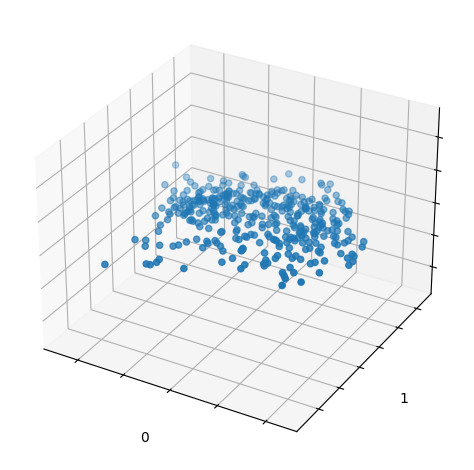

In [835]:
biom_table = Table(features_df.T.values, 
                   observation_ids=features_df.columns, 
                   sample_ids=features_df.index)

ordination_results, distance_matrix = rpca(biom_table, n_components=2)
ordination_results

In [836]:
ordination_df = pd.DataFrame(
    ordination_results.samples.values,
    index=ordination_results.samples.index,
    columns=[f"PC{i+1}" for i in range(ordination_results.samples.shape[1])]
)
ordination_df

,PC1,PC2,PC3
900344,-0.029703,-0.007066,0.0
900459,-0.051117,-0.016289,0.0
900221,-0.013035,-0.069949,0.0
900092,-0.013554,0.055445,0.0
900129,0.067166,0.042144,0.0
...,...,...,...
900484,0.011312,0.009538,0.0
900287,0.020628,0.001444,0.0
900057,0.015209,0.049444,0.0
9003972,0.027276,0.073283,0.0


In [837]:
# Add pid and group columns from metadata
ordination_df['pid'] = metadata.loc[ordination_df.index, 'pid']
ordination_df['group'] = metadata.loc[ordination_df.index, 'group']
ordination_df['microbiome_type'] = metadata.loc[ordination_df.index, 'microbiome_type']


In [838]:
# Fix group column to just 'AD' or 'Healthy'
ordination_df['group'] = ordination_df['group'].replace({
    'skin-ADL': 'AD', 'nares-AD': 'AD',
    'skin-ADNL': 'AD',  # if applicable
    'skin-H': 'Healthy', 'nares-H': 'Healthy'
})
ordination_df

,PC1,PC2,PC3,pid,group,microbiome_type
900344,-0.029703,-0.007066,0.0,Co-130-MM,Healthy,skin
900459,-0.051117,-0.016289,0.0,Ca-145-LM,AD,nares
900221,-0.013035,-0.069949,0.0,Ca-101-ID,AD,skin
900092,-0.013554,0.055445,0.0,Ca-023-EJ,AD,nares
900129,0.067166,0.042144,0.0,Ca-035-AR,AD,skin
...,...,...,...,...,...,...
900484,0.011312,0.009538,0.0,Ca-153-MN,AD,nares
900287,0.020628,0.001444,0.0,Co-117-TG,Healthy,skin
900057,0.015209,0.049444,0.0,Ca-013-NN,AD,skin
9003972,0.027276,0.073283,0.0,Ca-125-IM,AD,skin


In [839]:
distance_data = []


# Only keep individuals with both skin and nares samples
for pid, group in ordination_df[['pid', 'group']].drop_duplicates().values:
    subj = ordination_df[ordination_df['pid'] == pid]
    
    if {'skin', 'nares'}.issubset(set(subj['microbiome_type'])):
        # Extract ordination coordinates (exclude metadata columns)
        skin_coords = subj[subj['microbiome_type'] == 'skin'].iloc[0, :-3].values
        nares_coords = subj[subj['microbiome_type'] == 'nares'].iloc[0, :-3].values
        
        dist = euclidean(skin_coords, nares_coords)
        distance_data.append({'pid': pid, 'group': group, 'distance': dist})

distance_df = pd.DataFrame(distance_data)

distance_df

,pid,group,distance
0,Ca-145-LM,AD,0.104113
1,Ca-101-ID,AD,0.054731
2,Ca-023-EJ,AD,0.051447
3,Ca-035-AR,AD,0.052052
4,Co-152-AF,Healthy,0.165903
...,...,...,...
157,Ca-020-AZ,AD,0.046682
158,Co-115-SG,Healthy,0.144140
159,Ca-018-AS,AD,0.061996
160,Co-128-IV,Healthy,0.117715


In [840]:
# --- Create the boxplot ---
plt.figure(figsize=(5, 5))
sns.boxplot(
    data=distance_df,
    x='group',
    y='distance',
    order=['Healthy', 'AD'],
    palette={'AD': '#E31A1C', 'Healthy': '#ADD8E6'}
)

# --- Plot darker dots per group ---
sns.stripplot(
    data=distance_df[distance_df['group'] == 'Healthy'],
    x='group',
    y='distance',
    order=['Healthy', 'AD'],
    color='#3c6e91',  # darker blue for Healthy
    alpha=0.6,
    jitter=True
)

sns.stripplot(
    data=distance_df[distance_df['group'] == 'AD'],
    x='group',
    y='distance',
    order=['Healthy', 'AD'],
    color='#8b0000',  # darker red for AD
    alpha=0.6,
    jitter=True
)


# Labels
plt.xlabel('')
plt.ylabel('Skin–Nares Euclidean Distance', fontsize=12)
plt.title('Within-Subject Microbiome Distance', fontsize=15)

# --- Mann–Whitney U test ---
ad_dist = distance_df[distance_df['group'] == 'AD']['distance']
h_dist = distance_df[distance_df['group'] == 'Healthy']['distance']
stat, raw_p = mannwhitneyu(ad_dist, h_dist, alternative='two-sided')

# --- Add n to x-axis labels ---
n_h = len(h_dist)
n_ad = len(ad_dist)
xtick_labels = [f'Healthy Skin\nand Nares Pairs\n(n={n_h})', f'ADL Skin and\nNares AD Pairs\n(n={n_ad})']
plt.xticks([0, 1], xtick_labels, fontsize=12)

# --- FDR correction ---
pvals = [raw_p]
_, pvals_corrected, _, _ = multipletests(pvals, method='fdr_bh')
p_corrected = pvals_corrected[0]

# --- Annotate p-value with horizontal line ---
x1, x2 = 0, 1  # Healthy on left, AD on right
y = max(distance_df['distance']) * 0.98
h = 0.01  # vertical spacing above box
plt.plot([x1, x2], [y + h, y + h], lw=1, c='k')  # horizontal line only

# Add p-value text above line
plt.text(
    (x1 + x2) / 2, y + h + 0.001,
    f'* p={p_corrected:.3f}',
    ha='center',
    va='bottom',
    fontsize=10
)

plt.tight_layout()
plt.savefig('../Plots/Analysis_figures/Co-occurrence/rpca_skin_nares_distance_boxplot_corrected_annotated.png', dpi=600)


/Users/yangchen/miniforge3/envs/qiime2-metagenome-2024.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yangchen/miniforge3/envs/qiime2-metagenome-2024.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yangchen/miniforge3/envs/qiime2-metagenome-2024.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/yangchen/minifor